## Import libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import pad_sequences
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

import seaborn as sns
import re
import string
import imblearn
from imblearn.over_sampling import SMOTE

# save model
import joblib

2024-03-08 22:18:48.713457: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 22:18:49.100321: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 22:18:49.102001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 22:18:50.468005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Read dataset

In [2]:
l_dataset = pd.read_csv("../source-data/L-short.csv", delimiter=";", encoding="windows-1251")
c_dataset = pd.read_csv("../source-data/C-short.csv", delimiter=";", encoding="windows-1251")

In [16]:
l_dataset = l_dataset.dropna()
l_dataset

,Number,Date,UID,Desc,Group,Cat
0,1197646.0,2022-04-04 10:27:06.000,f57cf6c8-0dbd-48c0-991e-2087897e2d8d,Выдача инвентаря,Управление домом,Благоустройство
1,1197758.0,04.04.2022 14:00,e8529648-511e-4e1d-a46b-d9f3379c5246,Демонтировать лавку за домом возле магазина,Управление домом,Благоустройство
2,1201781.0,15.04.2022 16:28,ea25fc8c-bcae-44e4-a669-8c57a32f5351,Спилить тополь( от дороги 6-ой),Управление домом,Благоустройство
3,1202034.0,2022-04-17 16:22:33.057,b13bba64-2e2c-4b47-91c1-5a741088977c,"Вывезти мешки с листвой,с обратной стороны дома",Управление домом,Благоустройство
4,1204079.0,22.04.2022 11:26,a83be036-6c68-4194-bf59-90394faf98d5,"Закрепить качели, убрать строит. мусор. Устано...",Управление домом,Благоустройство
...,...,...,...,...,...,...
27055,1344823.0,26.12.2022 18:07,38976e40-c9f1-4a3e-8a73-9c90a586b0cb,Не горит свет над подъездами,Управление домом,Электроэнергия (Отсутствие)
27056,1344829.0,26.12.2022 19:07,dfdcc2f6-f41c-4a2c-bf73-6caaa7e4e678,Не горит свет при входе в подъезд,Управление домом,Электроэнергия (Отсутствие)
27057,1345874.0,30.12.2022 7:26,7d4590e0-ee21-496d-beae-dafd9955bf63,Нет освещения на территории садика,Управление домом,Электроэнергия (Отсутствие)
27058,1346029.0,30.12.2022 12:35,d5378a17-40ad-48b8-83e7-691b3b940727,Нет света в квартире,Управление домом,Электроэнергия (Отсутствие)


In [17]:
c_dataset = c_dataset.dropna()
c_dataset

,Number,Date,UID,Desc
0,1346291,01.01.2023 2:10,e87b2cfa-6159-4aa2-b789-3974a01e0b0a,Застряли в лифте
1,1346306,01.01.2023 11:44,4593c91a-8b75-46e4-83e5-557d730abea0,Течь кровли (забита ливневка)
2,1346324,2023-01-01 13:50:46.028,1ab8b15e-b18c-4ce0-80dc-da40a029289e,Течь кровли в коридоре квартиры ручьем.
3,1346326,01.01.2023 14:04,1ab8b15e-b18c-4ce0-80dc-da40a029289e,Течь кровли в коридоре квартиры ручьем.Состави...
4,1346330,2023-01-01 14:47:18.090,1ab8b15e-b18c-4ce0-80dc-da40a029289e,Заделать щели в стыках крыши над 33 и 34 квар...
...,...,...,...,...
12929,1425619,10.09.2023 16:54,bdfe1feb-812a-4b11-b445-151806c298c6,Составить акт о протопе на кухне соседями сверху
12930,1425635,10.09.2023 17:29,c2adf284-fac0-45f5-b5a1-aa6151dd2e96,Опломбировать счетчик ХВС после ремонтных работ
12931,1425640,10.09.2023 17:54,62f5beff-2753-490c-8115-01cfa320ee40,Обратная тяга вентканала в ванной
12932,1425642,10.09.2023 18:09,252cd76d-0344-418d-850f-74f04fdb007c,Не работает лифт в 1 под.


In [18]:
# shape dataset
l_dataset.shape, c_dataset.shape

((27058, 6), (12934, 4))

In [19]:
l_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27058 entries, 0 to 27059
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Number  27058 non-null  float64
 1   Date    27058 non-null  object 
 2   UID     27058 non-null  object 
 3   Desc    27058 non-null  object 
 4   Group   27058 non-null  object 
 5   Cat     27058 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.4+ MB


In [20]:
# check NaN
l_dataset.isna().sum(), c_dataset.isna().sum()

(Number    0
 Date      0
 UID       0
 Desc      0
 Group     0
 Cat       0
 dtype: int64,
 Number    0
 Date      0
 UID       0
 Desc      0
 dtype: int64)

In [21]:
# check balance of data
l_dataset['Group'].value_counts()

Управление домом                 24856
Лифты                             1269
Домофоны                           859
Благоустройство                     34
Бродячие животные                   14
Отопление                            5
Сантехника                           3
Электроэнергия                       3
Канализация                          3
Дороги                               2
Газоснабжение                        2
Водоотведение                        2
Диспетчеризация                      1
Ливневки                             1
Мусоропровод                         1
Приборы учета                        1
Уборка  придомовой территории        1
Вентиляция                           1
Name: Group, dtype: int64

In [22]:
l_dataset['Cat'].value_counts()

Отопление (Отсутствие)                         5546
Общие вопросы                                  4485
Отопление (Нарушение температурного режима)    3770
Электроэнергия                                 3014
Опломбировка ИПУ                               1825
                                               ... 
Замена арматуры с/б                               1
Подключение к диспетчеризации                     1
Восстановление связи                              1
Повреждения системы водоотвода                    1
Ликвидация воздушных пробок                       1
Name: Cat, Length: 74, dtype: int64

## Data Augmentation by googletrans + textattack

In [23]:
from textattack.augmentation import EasyDataAugmenter
from textattack.augmentation import WordNetAugmenter
from textattack.augmentation import EmbeddingAugmenter
from textattack.augmentation import CheckListAugmenter
from textattack.augmentation import CLAREAugmenter

import asyncio
import multiprocessing

/home/jeremie/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [24]:
from deep_translator import GoogleTranslator
MY_DEEPTRANS_API = '5046fb77012286730dd527cb9f2d8e30'

In [26]:
LANGUAGES = {
    'mt': 'maltese',
    'en': 'english', 
    'de': 'german', 
    'bg': 'bulgarian', 
    'pl': 'polish', 
    'pt': 'portuguese', 
    'hu': 'hungarian', 
    'ro': 'romanian', 
    'ru': 'russian', 
    'nl': 'dutch', 
    'slovakian': 'slovakian', 
    'el': 'greek', 
    'sl': 'slovenian', 
    'da': 'danish', 
    'it': 'italian', 
    'es': 'spanish', 
    'fi': 'finnish', 
    'chinese': 'chinese', 
    'fr': 'french', 
    'cs': 'czech', 
    'laotian': 'laotian', 
    'sv': 'swedish', 
    'lv': 'latvian', 
    'et': 'estonian'
}

In [27]:
languages = list(LANGUAGES.keys())
# aug_methods = ['easy', 'wordnet', 'embedding', 'checklist']
aug_methods = ['checklist', 'embedding', 'wordnet']
translators = ['google']#, 'pons', 'linguee',
              #'mymemory', 'libre'] # 'yandex'

async def rand_trans_utils(huge=False):
    idx_lang = round(np.random.uniform(0, len(languages) - 1))
    idx_aug_method = round(np.random.uniform(0, len(aug_methods) - 1))
    idx_trans = round(np.random.uniform(0, len(translators) - 1))

    # get aug method
    if aug_methods[idx_aug_method] == 'easy':
        rand_aug_method = EasyDataAugmenter()
    elif aug_methods[idx_aug_method] == 'wordnet':
        rand_aug_method = WordNetAugmenter()
    elif aug_methods[idx_aug_method] == 'checklist':
        rand_aug_method = CheckListAugmenter(pct_words_to_swap=0.2, transformations_per_example=3)
    elif aug_methods[idx_aug_method] == 'clare':
        rand_aug_method = CLAREAugmenter()
    else:
        rand_aug_method = EmbeddingAugmenter()
        
    translator = GoogleTranslator
        
    return languages[idx_lang], rand_aug_method, translator, idx_trans
    

In [28]:
async def back_translate(sequence, label, PROB = 1):
    output_sequence = []
    #store original language so we can convert back
    org_lang = 'ru'
    trans_lang = 'en'

    huge = False
    if len(sequence) > 50:
        huge = True
        
    #randomly choose language to translate sequence to
    target_lang, aug_method, translator, idx_trans = await rand_trans_utils(huge)
    translated = None
    aug_translated = None
    #translate to english, that is transform language
    try:
        translated = translator(source=LANGUAGES[org_lang], target=LANGUAGES[trans_lang]).translate(sequence)
        # print(aug_method.augment(translated))
        aug_translated = aug_method.augment(translated)
    except:
        print(f'{translators[idx_trans]} no support translate to {LANGUAGES[trans_lang]}')
        pass
        
    if translated:
        for se in aug_translated:
            translated_next = None
            if trans_lang != target_lang:
                try: 
                    translated_next = translator(source=LANGUAGES[trans_lang], target=LANGUAGES[target_lang]).translate(se)
                except:
                    # print(f'{translators[idx_trans]} no support translate to {LANGUAGES[target_lang]}')
                    break
            #translate back to original language
            if translated_next:
                translated_back = None
                try:
                    translated_back = translator(source=LANGUAGES[target_lang], target=LANGUAGES[org_lang]).translate(translated_next)
                except:
                    print(f'Finally, {translators[idx_trans]} no support translate to {LANGUAGES[org_lang]}')
                    pass
                
                #apply with certain probability
                if np.random.uniform(0, 1) <= PROB:
                    output_sequence.append([translated_back] + label)
    else:
        output_sequence = output_sequence
    output_sequence = [list(x) for x in set(tuple(x) for x in output_sequence)]
    return output_sequence


In [29]:
#check performance
text = l_dataset['Desc'][10] # sample text
group = l_dataset['Group'][10]
cate = l_dataset['Cat'][10]
label = [group, cate]

aug_result = []
while len(aug_result) < 20: # with 20 data more
    output = await back_translate(text, label)
    aug_result.extend(output)

2024-03-09 01:04:27,655 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [30]:
aug_result[:5]

[['Строительство и монтаж поручней в подъездах 3 и 4.',
  'Управление домом',
  'Благоустройство'],
 ['Изготовить и установить перила в 3 и 4 зале.',
  'Управление домом',
  'Благоустройство'],
 ['Изготовить и установить поручни в подъездах 3 и 4.',
  'Управление домом',
  'Благоустройство'],
 ['Изготовьте и установите перила у входа 3 и 4.',
  'Управление домом',
  'Благоустройство'],
 ['Строительство и монтаж забора в подъездах 6 и 4.',
  'Управление домом',
  'Благоустройство']]

**Applies to Group labels with quantities less than 100**

In [31]:
group_labels_less = l_dataset['Group'].value_counts()[l_dataset['Group'].value_counts() <= 100]

In [32]:
for i in range(len(l_dataset)):
    if l_dataset.loc[i, 'Group'] in group_labels_less.index:
        text = l_dataset.loc[i, 'Desc']
        group = l_dataset.loc[i, 'Group']
        cate = l_dataset.loc[i, 'Cat']
        cur_nums = group_labels_less[l_dataset.loc[i, 'Group']]

        label = [group, cate]

        if cur_nums > 10:
            more = 5
        else:
            more = 50
            
        aug_result = []
        while len(aug_result) < more: # with 20 data more
            output = await back_translate(text, label)
            aug_result.extend(output)

        # convert to list
        aug_result = list(list(x) for x in aug_result)
        l_dataset = pd.concat([l_dataset, pd.DataFrame(aug_result, columns=['Desc', 'Group', 'Cat'])], ignore_index=True)

[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Down

Finally, google no support translate to russian


[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


google no support translate to english


[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Down

In [33]:
l_dataset.shape

(28604, 6)

In [34]:
l_dataset['Group'].value_counts()

Управление домом                 24856
Лифты                             1269
Домофоны                           859
Отопление                          255
Благоустройство                    206
Канализация                        153
Сантехника                         153
Электроэнергия                     153
Водоотведение                      104
Дороги                             102
Газоснабжение                      102
Бродячие животные                   86
Диспетчеризация                     51
Вентиляция                          51
Ливневки                            51
Мусоропровод                        51
Приборы учета                       51
Уборка  придомовой территории       51
Name: Group, dtype: int64

**Augmentation for category**

In [35]:
cat_labels_less = l_dataset['Cat'].value_counts()[l_dataset['Cat'].value_counts() <= 100]
cat_labels_less[:10], cat_labels_less.shape

(Опломбирование приборов                              100
 Проверка ДВК                                          97
 Неисправности  освещения в общедомовых помещениях     91
 Ремонт дымовых и вентиляционных каналов               84
 Ливнёвки                                              78
 Кровля                                                57
 Засор канал                                           53
 Отключение системы электроснабжения                   52
 Восстановление связи                                  51
 Отключение стояков отопления                          51
 Name: Cat, dtype: int64,
 (50,))

In [36]:
# with no parallel, it takes more than x hours

for i in range(len(l_dataset)):
    if l_dataset.loc[i, 'Cat'] in cat_labels_less.index:
        text = l_dataset.loc[i, 'Desc']
        group = l_dataset.loc[i, 'Group']
        cate = l_dataset.loc[i, 'Cat']
        cur_nums = cat_labels_less[l_dataset.loc[i, 'Cat']]

        label = [group, cate]

        if cur_nums > 50:
            more = 2
        elif cur_nums >= 10:
            more = 5
        else:
            more = 50
            
        aug_result = []
        while len(aug_result) < more: # with 20 data more
            output = await back_translate(text, label)
            aug_result.extend(output)

        # convert to list
        aug_result = list(list(x) for x in aug_result)
        l_dataset = pd.concat([l_dataset, pd.DataFrame(aug_result, columns=['Desc', 'Group', 'Cat'])], ignore_index=True)


[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Down

Finally, google no support translate to russian


[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Down

In [37]:
l_dataset['Cat'].value_counts()

Общие вопросы                                                         5704
Отопление (Отсутствие)                                                5546
Отопление (Нарушение температурного режима)                           3770
Электроэнергия                                                        3014
Опломбировка ИПУ                                                      1825
                                                                      ... 
Течи в водопроводных кранах и в кранах сливных бачков при унитазах      51
Произвести механизирован.уборку терр                                    51
Повреждения системы водоотвода                                          51
Подключение к диспетчеризации                                           51
произвести механизированную уборку территории                           51
Name: Cat, Length: 74, dtype: int64

In [38]:
# save to csv file
l_dataset.to_csv('../source-data/L-augment.csv', index=False)

## Cleaning data after augmentation

In [56]:
l_dataset_aug = pd.read_csv("../source-data/L-augment.csv")

In [57]:
l_dataset_aug['Desc and Group'] = l_dataset_aug['Desc'] + '. ' + l_dataset_aug['Group']

In [58]:
l_dataset_aug.head()

,Number,Date,UID,Desc,Group,Cat,Desc and Group
0,1197646.0,2022-04-04 10:27:06.000,f57cf6c8-0dbd-48c0-991e-2087897e2d8d,Выдача инвентаря,Управление домом,Благоустройство,Выдача инвентаря. Управление домом
1,1197758.0,04.04.2022 14:00,e8529648-511e-4e1d-a46b-d9f3379c5246,Демонтировать лавку за домом возле магазина,Управление домом,Благоустройство,Демонтировать лавку за домом возле магазина . ...
2,1201781.0,15.04.2022 16:28,ea25fc8c-bcae-44e4-a669-8c57a32f5351,Спилить тополь( от дороги 6-ой),Управление домом,Благоустройство,Спилить тополь( от дороги 6-ой). Управление д...
3,1202034.0,2022-04-17 16:22:33.057,b13bba64-2e2c-4b47-91c1-5a741088977c,"Вывезти мешки с листвой,с обратной стороны дома",Управление домом,Благоустройство,"Вывезти мешки с листвой,с обратной стороны дом..."
4,1204079.0,22.04.2022 11:26,a83be036-6c68-4194-bf59-90394faf98d5,"Закрепить качели, убрать строит. мусор. Устано...",Управление домом,Благоустройство,"Закрепить качели, убрать строит. мусор. Устано..."


In [59]:
# Remove duplicated rows
l_dataset_aug = l_dataset_aug.drop_duplicates(subset=['Desc', 'Group', 'Cat'], keep='first')
l_dataset_aug.shape

(23929, 7)

In [60]:
l_dataset_aug['Length'] = l_dataset_aug['Desc'].apply(lambda x: len(str(x)))

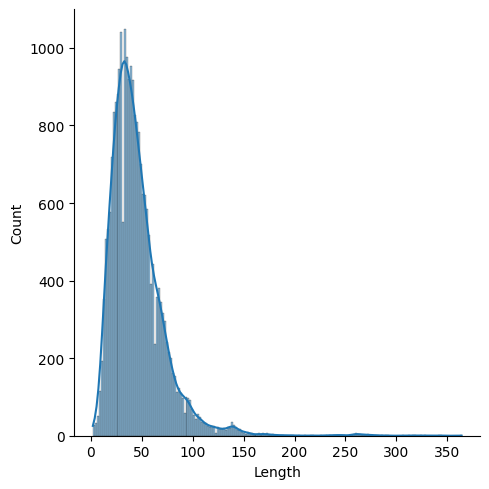

In [61]:
sns.displot(l_dataset_aug['Length'], kde=True)

## Preprocessing

In [64]:
def convert_to_lower(text):
    return text.lower()
    
def remove_numbers(text):
    return re.sub(pattern=r'\d+', repl=" ", string=text)
    
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("russian"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remmove_extra_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def preprocessing_desc():
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc'].apply(lambda x: convert_to_lower(str(x)))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_numbers(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_punctuation(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_stopwords(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remmove_extra_spaces(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: lemmatizing(x))
    l_dataset_aug['Length after clean'] = l_dataset_aug['Desc clean'].apply(lambda x: len(x))

def preprocessing_desc_and_group():
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc and Group'].apply(lambda x: convert_to_lower(str(x)))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_numbers(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_punctuation(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_stopwords(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remmove_extra_spaces(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: lemmatizing(x))

In [65]:
preprocessing_desc()
l_dataset_aug['Desc clean'][:5]

0                                     выдача инвентаря
1             демонтировать лавку домом возле магазина
2                             спилить тополь дороги ой
3         вывезти мешки листвойс обратной стороны дома
4    закрепить качели убрать строит мусор установит...
Name: Desc clean, dtype: object

In [66]:
preprocessing_desc_and_group()

# After preprocessing
l_dataset_aug['Desc Group clean'][:5]

0                    выдача инвентаря управление домом
1    демонтировать лавку домом возле магазина управ...
2            спилить тополь дороги ой управление домом
3    вывезти мешки листвойс обратной стороны дома у...
4    закрепить качели убрать строит мусор установит...
Name: Desc Group clean, dtype: object

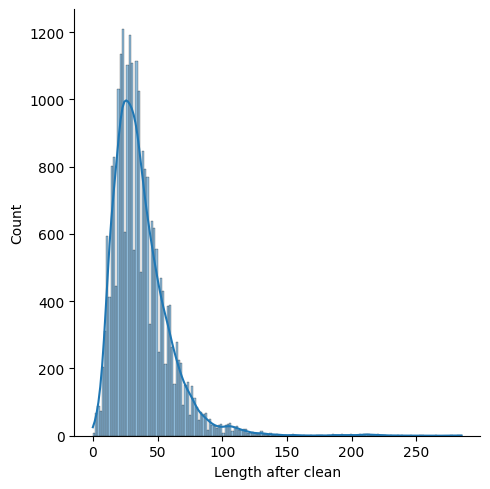

In [67]:
sns.displot(l_dataset_aug['Length after clean'], kde=True)

### Defined multiclass-logloss

In [68]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """
    Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    if len(actual.shape) == 1:
        tmp = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            tmp[i, val] = 1
        actual = tmp

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

## Prepare training data

In [69]:
## Get train data and label
x_train = l_dataset_aug["Desc clean"]
x_train.shape

(23929,)

In [70]:
## Get train data from desc and group for predict category
x_train_cat_degr = l_dataset_aug["Desc Group clean"]
x_train_cat_degr.shape


(23929,)

In [71]:
y_train_group = l_dataset_aug["Group"] 
y_train_group.shape

(23929,)

In [72]:
y_train_cat = l_dataset_aug["Cat"] 
y_train_cat.shape

(23929,)

In [73]:
# Label encoding for target group
lb_encoding = preprocessing.LabelEncoder()
y_train_group_encoded = lb_encoding.fit_transform(y_train_group)
y_train_group_encoded[:5]

array([16, 16, 16, 16, 16])

In [74]:
# Label encoding for target category
y_train_cat_encoded = lb_encoding.fit_transform(y_train_cat)
y_train_cat_encoded[:5]

array([0, 0, 0, 0, 0])

In [75]:
# split train and valid data for group
x_train_group, x_valid_group, y_train_group, y_valid_group = train_test_split(x_train.values, y_train_group_encoded,
                                                                  stratify=y_train_group_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [76]:
x_train_cat, x_valid_cat, y_train_cat, y_valid_cat = train_test_split(x_train.values, y_train_cat_encoded,
                                                                  stratify=y_train_cat_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [77]:
x_train_cat_new, x_valid_cat_new, y_train_cat_new, y_valid_cat_new = train_test_split(x_train_cat_degr.values, y_train_cat_encoded,
                                                                  stratify=y_train_cat_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [78]:
x_train_group.shape, x_valid_group.shape

((19143,), (4786,))

In [79]:
x_train_cat.shape, x_valid_cat.shape, x_train_cat_new.shape

((19143,), (4786,), (19143,))

## Building effective models

### Implementing text with TfidfVectorizer followed by a simple Logistic Regression

In [80]:
tfv = TfidfVectorizer(min_df=3, max_features=None,
                          strip_accents='unicode',
                          analyzer='word',
                          token_pattern=r'\w{1,}',
                          ngram_range=(1, 3),
                          use_idf=1,
                          smooth_idf=1,
                          sublinear_tf=1) ## add stop words

# Fitting TF-IDF
tfv.fit(list(x_train))
x_train_group_tfv = tfv.transform(x_train_group)
x_valid_group_tfv = tfv.transform(x_valid_group)

x_train_cat_tfv = tfv.transform(x_train_cat)
x_valid_cat_tfv = tfv.transform(x_valid_cat)

x_train_cat_new_tfv = tfv.transform(x_train_cat_new)
x_valid_cat_new_tfv = tfv.transform(x_valid_cat_new)

/home/jeremie/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:541: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [81]:
# Fitting a simple Logistic Regression for TF-IDF
# model for group
print('Fitting TF-TDF with group label ...')
clf_tfv_group = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_group.fit(x_train_group_tfv, y_train_group)
print('Done.')
print('-' * 50)
# model for cat
print('Fitting TF-TDF with category label ...')
clf_tfv_cat = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat.fit(x_train_cat_tfv, y_train_cat)
print('Done.')
print('-' * 50)
# model for cat new
print('Fitting TF-TDF with category label with new data ...')
clf_tfv_cat_new = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat_new.fit(x_train_cat_new_tfv, y_train_cat)
print('Done.')

Fitting TF-TDF with group label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label with new data ...
Done.


**Predict for group**

In [82]:
predicted_group = clf_tfv_group.predict_proba(x_valid_group_tfv)
classify_group = [np.argmax(x) for x in predicted_group]

print("log loss for group: %0.3f" % multiclass_logloss(y_valid_group, predicted_group)) # last: 0.046
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.949

log loss for group: 0.211
accuracy for group: 0.944


**Predict for category**

In [83]:
predicted_cat = clf_tfv_cat.predict_proba(x_valid_cat_tfv)
classify_cat = [np.argmax(x) for x in predicted_cat]

print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat)) # last: 0.677
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

log loss for category: 1.319
accuracy for category: 0.660


**Predict for category new**

In [84]:
predicted_cat_new = clf_tfv_cat_new.predict_proba(x_valid_cat_new_tfv)
classify_cat_new = [np.argmax(x) for x in predicted_cat_new]

print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat_new)) # last: 0.686
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss for category: 1.283
accuracy for category: 0.657


**Save model**

In [85]:
path_model_group_tfv = '../model/LogisticRegression/tfv/clf_tfv_group.sav'
path_model_cat_tfv = '../model/LogisticRegression/tfv/clf_tfv_cat.sav'
path_model_cat_new_tfv = '../model/LogisticRegression/tfv/clf_tfv_cat_new.sav'

In [88]:
joblib.dump(clf_tfv_group, path_model_group_tfv)
joblib.dump(clf_tfv_group, path_model_cat_tfv)
joblib.dump(clf_tfv_group, path_model_cat_new_tfv)

['../model/LogisticRegression/tfv/clf_tfv_cat_new.sav']

### Implementing text with CountVectorizer followed by a simple Logistic Regression

In [89]:
ctv = CountVectorizer(analyzer='word',
                         token_pattern=r'\w{1,}',
                         ngram_range=(1, 3),
                         # stop_words = 'russian'
                     )
# Fitting CountVectorizer
ctv.fit(list(x_train))
x_train_group_ctv = ctv.transform(x_train_group)
x_valid_group_ctv = ctv.transform(x_valid_group)

x_train_cat_ctv = ctv.transform(x_train_cat)
x_valid_cat_ctv = ctv.transform(x_valid_cat)

x_train_cat_new_ctv = ctv.transform(x_train_cat_new)
x_valid_cat_new_ctv = ctv.transform(x_valid_cat_new)

In [90]:
# Fitting a simple Logistic Regression for Count Vetorizer
# model for group
print('Fitting CountVectorizer with group label ...')
clf_ctv_group = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_group.fit(x_train_group_ctv, y_train_group)
print('Done.')
print('-' * 50)
# model for cat 
print('Fitting CountVectorizer with cat label ...')
clf_ctv_cat = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat.fit(x_train_cat_ctv, y_train_cat)
print('Done.')
print('-' * 50)
print('Fitting CountVectorizer with cat label with new data...')
clf_ctv_cat_new = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat_new.fit(x_train_cat_new_ctv, y_train_cat)
print('Done.')

Fitting CountVectorizer with group label ...
Done.
--------------------------------------------------
Fitting CountVectorizer with cat label ...
Done.
--------------------------------------------------
Fitting CountVectorizer with cat label with new data...
Done.


**Predict for group**

In [91]:
predicted_ctv_group = clf_ctv_group.predict_proba(x_valid_group_ctv)
classify_group = [np.argmax(x) for x in predicted_ctv_group]

print("log loss: %0.3f" % multiclass_logloss(y_valid_group, predicted_ctv_group))
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.961

log loss: 0.155
accuracy for group: 0.953


**Predict for category**

In [92]:
predicted_ctv_cat = clf_ctv_cat.predict_proba(x_valid_cat_ctv)
classify_cat = [np.argmax(x) for x in predicted_ctv_cat]

print("log loss: %0.3f" % multiclass_logloss(y_valid_cat, predicted_ctv_cat))
print("accuracy for category: %0.3f" % accuracy_score(classify_cat, y_valid_cat)) # last 0.704

log loss: 1.048
accuracy for category: 0.687


**Predict for category with new data**

In [93]:
predicted_ctv_cat_new = clf_ctv_cat_new.predict_proba(x_valid_cat_new_ctv)
classify_cat_new = [np.argmax(x) for x in predicted_ctv_cat_new]

print("log loss: %0.3f" % multiclass_logloss(y_valid_cat, predicted_ctv_cat_new))
print("accuracy for category: %0.3f" % accuracy_score(classify_cat_new, y_valid_cat)) #last 0.722

log loss: 0.954
accuracy for category: 0.705


**Save model**

In [94]:
path_model_group_ctv = '../model/LogisticRegression/ctv/clf_ctv_group.sav'
path_model_cat_ctv = '../model/LogisticRegression/ctv/clf_ctv_cat.sav'
path_model_cat_new_ctv = '../model/LogisticRegression/ctv/clf_ctv_cat_new.sav'

In [95]:
joblib.dump(clf_ctv_group, path_model_group_ctv)
joblib.dump(clf_ctv_cat, path_model_cat_ctv)
joblib.dump(clf_ctv_cat_new, path_model_cat_new_ctv)

['../model/LogisticRegression/ctv/clf_ctv_cat_new.sav']

## XGBoost

**Use tfv features**

Fitting a simple xgboost on tfv

In [96]:
# use tfv 
clf_xg_tfv = xgb.XGBClassifier(max_depth=7,
                            n_estimators=200,
                            colsample_bytree=0.8,
                            subsample=0.8,
                            nthread=10,
                            learning_rate=0.1)

In [97]:
# for group
clf_xg_tfv.fit(x_train_group_tfv.tocsc(), y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for group**

In [98]:
# predict for group
predicted_tfv_group = clf_xg_tfv.predict_proba(x_valid_group_tfv.tocsc())
classify_group_xg = [np.argmax(x) for x in predicted_tfv_group]

print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_tfv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

log loss: 0.200 
accuracy for group: 0.951


In [99]:
# save
path_model_group_tfv = '../model/XGBoost/tfv/clf_xg_tfv_group.sav'
joblib.dump(clf_xg_tfv, path_model_group_tfv)

['../model/XGBoost/tfv/clf_xg_tfv_group.sav']

In [100]:
# for category
clf_xg_tfv.fit(x_train_cat_tfv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category**

In [101]:
# predict for cat
predicted_tfv_cat = clf_xg_tfv.predict_proba(x_valid_cat_tfv.tocsc())
classify_cat_xg = [np.argmax(x) for x in predicted_tfv_cat]

In [102]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_tfv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.198 
accuracy for cat: 0.647


In [103]:
# save for clf category model
path_model_cat_tfv = '../model/XGBoost/tfv/clf_xg_tfv_cat.sav'
joblib.dump(clf_xg_tfv, path_model_cat_tfv)

['../model/XGBoost/tfv/clf_xg_tfv_cat.sav']

In [104]:
# for category new
clf_xg_tfv.fit(x_train_cat_new_tfv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category with new data**

In [105]:
# predict for cat
predicted_tfv_cat_new = clf_xg_tfv.predict_proba(x_valid_cat_new_tfv.tocsc())
classify_cat_xg_new = [np.argmax(x) for x in predicted_tfv_cat_new]

print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_tfv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 1.084 
accuracy for cat: 0.664


**Save model**

In [106]:
path_model_cat_new_tfv = '../model/XGBoost/tfv/clf_xg_tfv_cat_new.sav'

In [107]:
joblib.dump(clf_ctv_cat_new, path_model_cat_new_tfv)

['../model/XGBoost/tfv/clf_xg_tfv_cat_new.sav']

**Use count features**

Fitting a simple xgboost on counter

In [108]:
 # use ctv 
clf_xg_ctv = xgb.XGBClassifier(max_depth=7,
                               n_estimators=200,
                               colsample_bytree=0.8,
                               subsample=0.8,
                               nthread=10,
                               learning_rate=0.1)

In [109]:
# for group
clf_xg_ctv.fit(x_train_group_ctv.tocsc(), y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for group**

In [110]:
# predict for group
predicted_ctv_group = clf_xg_ctv.predict_proba(x_valid_group_ctv.tocsc())
classify_group_xg = [np.argmax(x) for x in predicted_ctv_group]

print ("logloss: %0.3f " % multiclass_logloss(y_valid_group, predicted_ctv_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

logloss: 0.206 
accuracy for cat: 0.948


In [111]:
# save clf group model on ctv
path_model_group_ctv = '../model/XGBoost/ctv/clf_xg_ctv_group.sav'
joblib.dump(clf_xg_ctv, path_model_group_ctv)

['../model/XGBoost/ctv/clf_xg_ctv_group.sav']

In [112]:
# for category
clf_xg_ctv.fit(x_train_cat_ctv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category**

In [113]:
# predict for cat
predicted_ctv_cat = clf_xg_ctv.predict_proba(x_valid_cat_ctv.tocsc())
classify_cat_xg = [np.argmax(x) for x in predicted_ctv_cat]

print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_ctv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.116 
accuracy for cat: 0.665


In [114]:
# save clf group model on ctv
path_model_cat_ctv = '../model/XGBoost/ctv/clf_xg_ctv_cat.sav'
joblib.dump(clf_xg_ctv, path_model_cat_ctv)

['../model/XGBoost/ctv/clf_xg_ctv_cat.sav']

In [115]:
# for category
clf_xg_ctv.fit(x_train_cat_new_ctv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category with new data**

In [116]:
# predict for cat
predicted_ctv_cat_new = clf_xg_ctv.predict_proba(x_valid_cat_new_ctv.tocsc())
classify_cat_xg_new = [np.argmax(x) for x in predicted_ctv_cat_new]

print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_ctv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 1.000 
accuracy for cat: 0.683


**Save model**

In [117]:
path_model_cat_new_ctv = '../model/XGBoost/ctv/clf_xg_ctv_cat_new.sav'

In [118]:
joblib.dump(clf_xg_ctv, path_model_cat_new_ctv)

['../model/XGBoost/ctv/clf_xg_ctv_cat_new.sav']